In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.transforms import ToTensor
from PIL import Image
import io

In [1]:
!git clone https://github.com/yformer/EfficientSAM.git
import os
os.chdir("EfficientSAM")

Cloning into 'EfficientSAM'...
remote: Enumerating objects: 424, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 424 (delta 76), reused 52 (delta 52), pack-reused 339
Receiving objects: 100% (424/424), 262.14 MiB | 1.62 MiB/s, done.
Resolving deltas: 100% (246/246), done.
Updating files: 100% (38/38), done.


In [2]:
from efficient_sam.build_efficient_sam import build_efficient_sam_vitt, build_efficient_sam_vits
import zipfile

efficient_sam_vitt_model = build_efficient_sam_vitt()
efficient_sam_vitt_model.eval()

# Since EfficientSAM-S checkpoint file is >100MB, we store the zip file.
with zipfile.ZipFile("weights/efficient_sam_vits.pt.zip", 'r') as zip_ref:
    zip_ref.extractall("weights")
efficient_sam_vits_model = build_efficient_sam_vits()
efficient_sam_vits_model.eval()



EfficientSam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (proj): Linear(in_features=384, out_features=384, bias=True)
        )
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(384, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    

In [3]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.8])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(
        pos_points[:, 0],
        pos_points[:, 1],
        color="green",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )
    ax.scatter(
        neg_points[:, 0],
        neg_points[:, 1],
        color="red",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(
        plt.Rectangle((x0, y0), w, h, edgecolor="yellow", facecolor=(0, 0, 0, 0), lw=5)
    )

def show_anns_ours(mask, ax):
    ax.set_autoscale_on(False)
    img = np.ones((mask.shape[0], mask.shape[1], 4))
    img[:, :, 3] = 0
    color_mask = [0, 1, 0, 0.7]
    img[np.logical_not(mask)] = color_mask
    ax.imshow(img)

In [4]:

def run_ours_box_or_points(img_path, pts_sampled, pts_labels, model):
    image_np = np.array(Image.open(img_path))
    img_tensor = ToTensor()(image_np)
    pts_sampled = torch.reshape(torch.tensor(pts_sampled), [1, 1, -1, 2])
    pts_labels = torch.reshape(torch.tensor(pts_labels), [1, 1, -1])
    predicted_logits, predicted_iou = model(
        img_tensor[None, ...],
        pts_sampled,
        pts_labels,
    )

    sorted_ids = torch.argsort(predicted_iou, dim=-1, descending=True)
    predicted_iou = torch.take_along_dim(predicted_iou, sorted_ids, dim=2)
    predicted_logits = torch.take_along_dim(
        predicted_logits, sorted_ids[..., None, None], dim=2
    )

    return torch.ge(predicted_logits[0, 0, 0, :, :], 0).cpu().detach().numpy()

#### Object Detection Model 

In [5]:
# Note that this script was pulled from here: https://pytorch.org/vision/main/models#object-detection
# Imports
from torchvision.io.image import read_image

# Explore the torchvision documentation to apply the other models and their weights
from torchvision.models.detection import (
    fasterrcnn_resnet50_fpn_v2,
    FasterRCNN_ResNet50_FPN_V2_Weights,
)
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image
from IPython.display import display

In [6]:
img = read_image("/Users/aisaiahpellecer/Desktop/lclabs-jfp24/early_work/images/image_3.jpg")

In [7]:
weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn_v2(weights=weights, box_score_thresh=0.9)
model.eval()

# Step 2: Initialize the inference transforms
preprocess = weights.transforms()

# Step 3: Apply inference preprocessing transforms
batch = [preprocess(img)]

# Step 4: Use the model and visualize the prediction
prediction = model(batch)[0]
labels = [weights.meta["categories"][i] for i in prediction["labels"]]
box = draw_bounding_boxes(
    img, boxes=prediction["boxes"], labels=labels, colors="red", width=4, font_size=30
)
im = to_pil_image(box.detach())
# im.show()

# Displays the Image
# display(im)

/Users/aisaiahpellecer/Desktop/LOC/loc-env/lib/python3.9/site-packages/torchvision/utils.py:223: UserWarning: Argument 'font_size' will be ignored since 'font' is not set.
  warnings.warn("Argument 'font_size' will be ignored since 'font' is not set.")


In [8]:
print(weights.meta["categories"][prediction['labels'][0].item()])

bowl


In [9]:
print(prediction['boxes'][0][0].item())
print(prediction['boxes'][0][1].item())
print(prediction['boxes'][0][2].item())
print(prediction['boxes'][0][3].item())
#  Tensor of size (N, 4) containing bounding boxes in (xmin, ymin, xmax, ymax) format. 
# Note that the boxes are absolute coordinates with respect to the image. In other word

582.1052856445312
273.7629089355469
773.5405883789062
411.4350891113281


In [10]:
x1=prediction['boxes'][0][0].item()
y1=prediction['boxes'][0][1].item() 
x2=prediction['boxes'][0][2].item() 
y2=prediction['boxes'][0][3].item() 
w=x2-x1
h=y2-y1

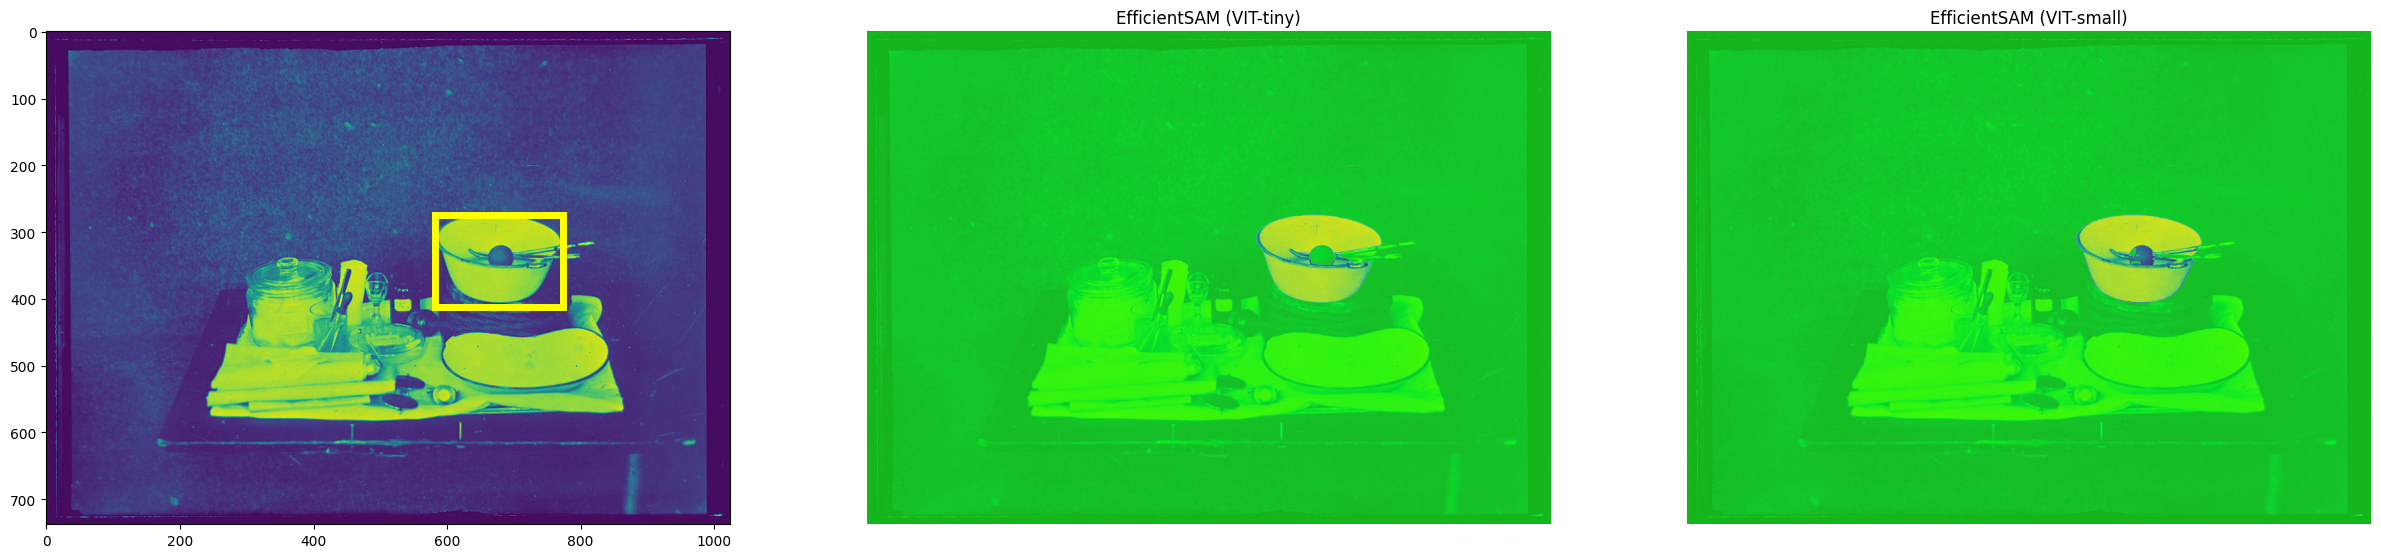

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(30, 30))
input_point = np.array([[x1, y1], [x2, y2]])
input_label = np.array([2,3])
image_path = '/Users/aisaiahpellecer/Desktop/lclabs-jfp24/early_work/images/image_3.jpg'
image = np.array(Image.open(image_path))
show_points(input_point, input_label, ax[0])
show_box([x1,y1,x2,y2], ax[0])
ax[0].imshow(image)

ax[1].imshow(image)
mask_efficient_sam_vitt = run_ours_box_or_points(image_path, input_point, input_label, efficient_sam_vitt_model)
show_anns_ours(mask_efficient_sam_vitt, ax[1])
ax[1].title.set_text("EfficientSAM (VIT-tiny)")
ax[1].axis('off')


ax[2].imshow(image)
mask_efficient_sam_vits = run_ours_box_or_points(image_path, input_point, input_label, efficient_sam_vits_model)
show_anns_ours(mask_efficient_sam_vits, ax[2])
ax[2].title.set_text("EfficientSAM (VIT-small)")
ax[2].axis('off')

plt.show()

In [59]:
img = read_image("/Users/aisaiahpellecer/Desktop/lclabs-jfp24/early_work/images/image_41.jpg")

In [60]:
batch = [preprocess(img)]

# Step 4: Use the model and visualize the prediction
prediction = model(batch)[0]
labels = [weights.meta["categories"][i] for i in prediction["labels"]]
box = draw_bounding_boxes(
    img, boxes=prediction["boxes"], labels=labels, colors="red", width=4, font_size=30
)
im = to_pil_image(box.detach())

In [63]:
x1=prediction['boxes'][0][0].item() 
y1=prediction['boxes'][0][1].item()
x2=prediction['boxes'][0][2].item() 
y2=prediction['boxes'][0][3].item() 
w=x2-x1
h=y2-y1

In [62]:
print(weights.meta["categories"][prediction['labels'][0].item()])

person


(-0.5, 739.5, 1023.5, -0.5)

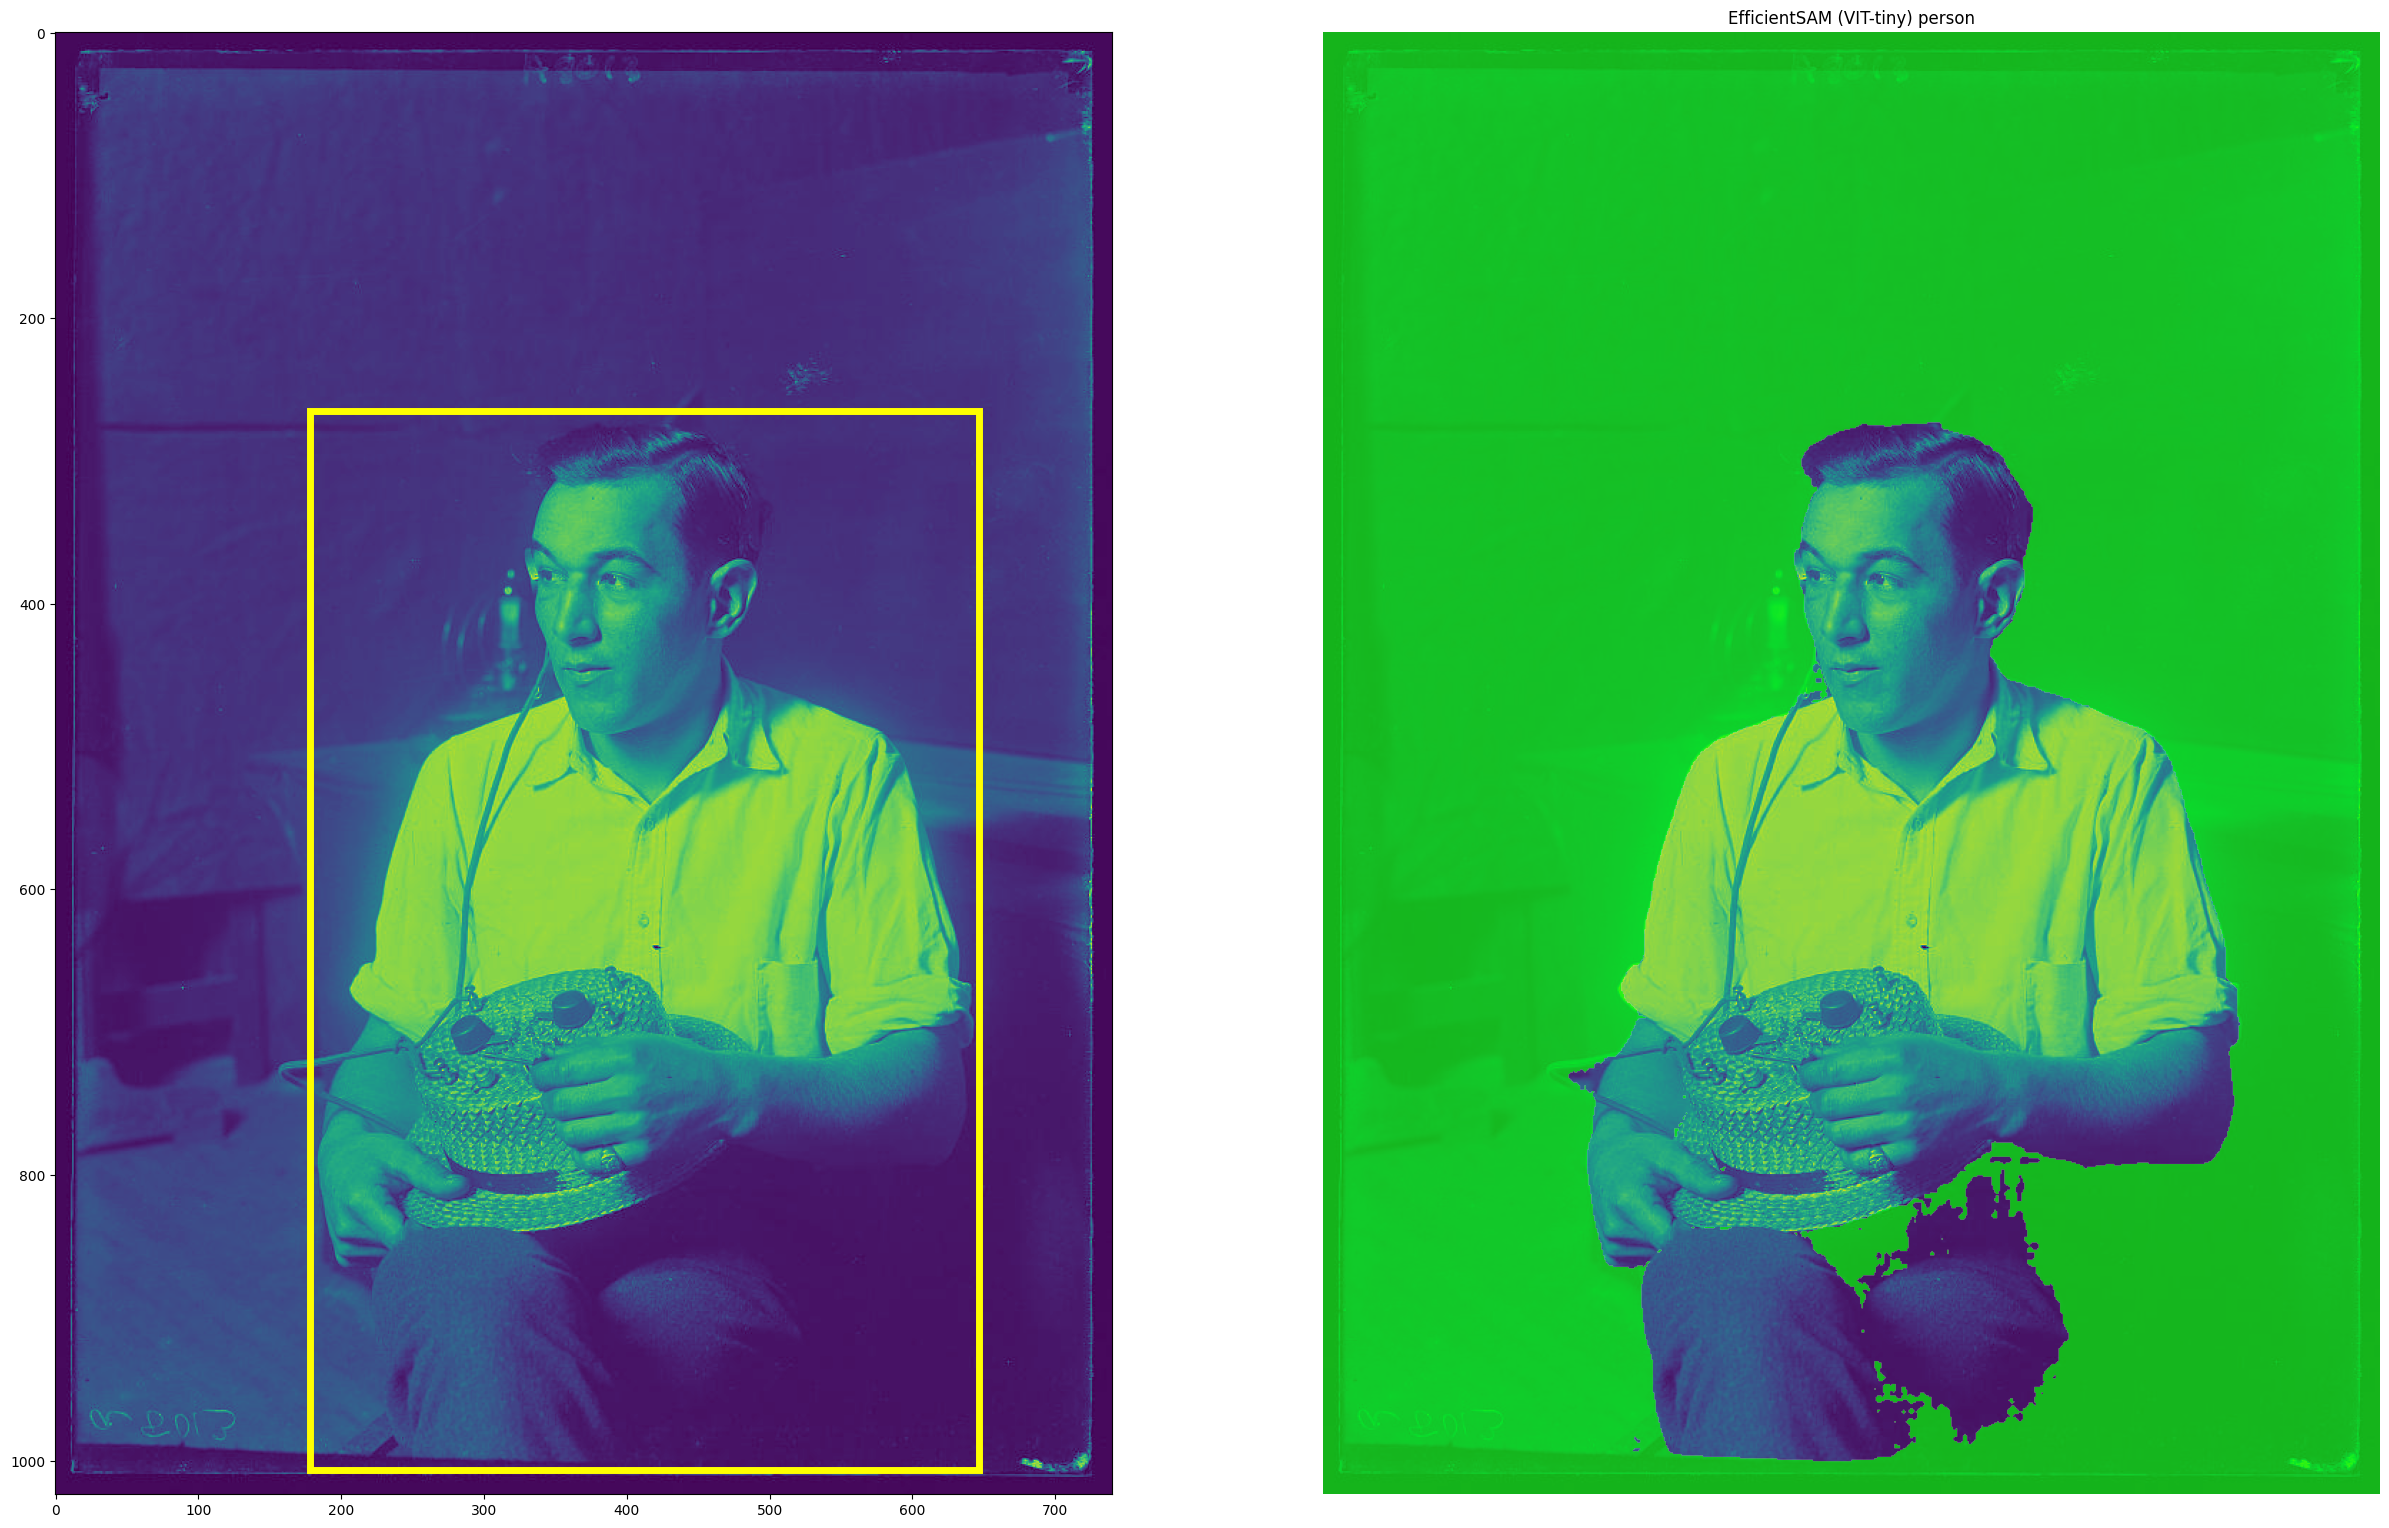

In [66]:
fig, ax = plt.subplots(1, 2, figsize=(30, 30))
input_point = np.array([[x1, y1], [x2, y2]])
input_label = np.array([2,3])
image_path = '/Users/aisaiahpellecer/Desktop/lclabs-jfp24/early_work/images/image_41.jpg'
image = np.array(Image.open(image_path))
show_points(input_point, input_label, ax[0])
show_box([x1,y1,x2,y2], ax[0])
ax[0].imshow(image)

ax[1].imshow(image)
mask_efficient_sam_vitt = run_ours_box_or_points(image_path, input_point, input_label, efficient_sam_vitt_model)
show_anns_ours(mask_efficient_sam_vitt, ax[1])
ax[1].title.set_text(f"EfficientSAM (VIT-tiny) {weights.meta['categories'][prediction['labels'][0].item()]}")
ax[1].axis('off')

(-0.5, 5036.5, 3421.5, -0.5)

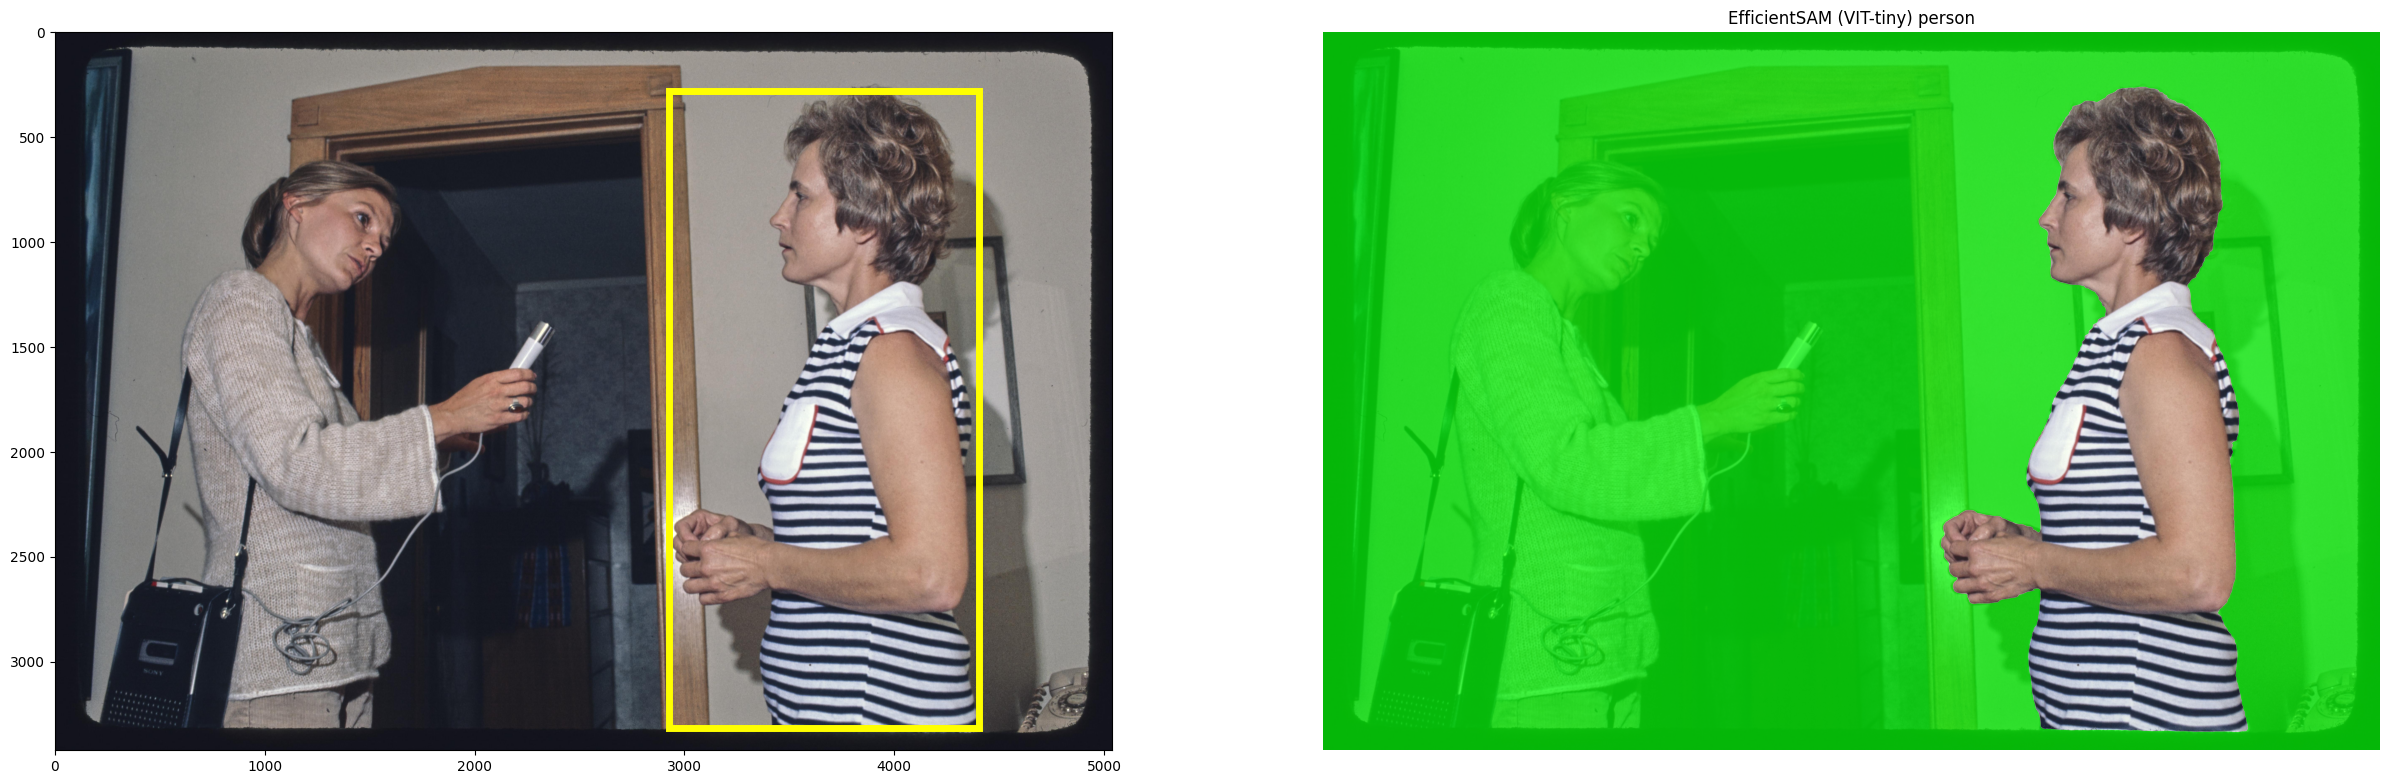

In [68]:
img = read_image('/Users/aisaiahpellecer/Downloads/test_color.jpeg')

batch = [preprocess(img)]

# Step 4: Use the model and visualize the prediction
prediction = model(batch)[0]
# labels = [weights.meta["categories"][i] for i in prediction["labels"]]
# box = draw_bounding_boxes(
#     img, boxes=prediction["boxes"], labels=labels, colors="red", width=4, font_size=30
# )
# im = to_pil_image(box.detach())

x1=prediction['boxes'][0][0].item() 
y1=prediction['boxes'][0][1].item()
x2=prediction['boxes'][0][2].item() 
y2=prediction['boxes'][0][3].item() 
w=x2-x1
h=y2-y1

fig, ax = plt.subplots(1, 2, figsize=(30, 30))
input_point = np.array([[x1, y1], [x2, y2]])
input_label = np.array([2,3])
image_path = '/Users/aisaiahpellecer/Downloads/test_color.jpeg'
image = np.array(Image.open(image_path))
show_points(input_point, input_label, ax[0])
show_box([x1,y1,x2,y2], ax[0])
ax[0].imshow(image)

ax[1].imshow(image)
mask_efficient_sam_vitt = run_ours_box_or_points(image_path, input_point, input_label, efficient_sam_vitt_model)
show_anns_ours(mask_efficient_sam_vitt, ax[1])
ax[1].title.set_text(f"EfficientSAM (VIT-tiny)\n{weights.meta['categories'][prediction['labels'][0].item()]}")
ax[1].axis('off')

(-0.5, 2520.5, 1713.5, -0.5)

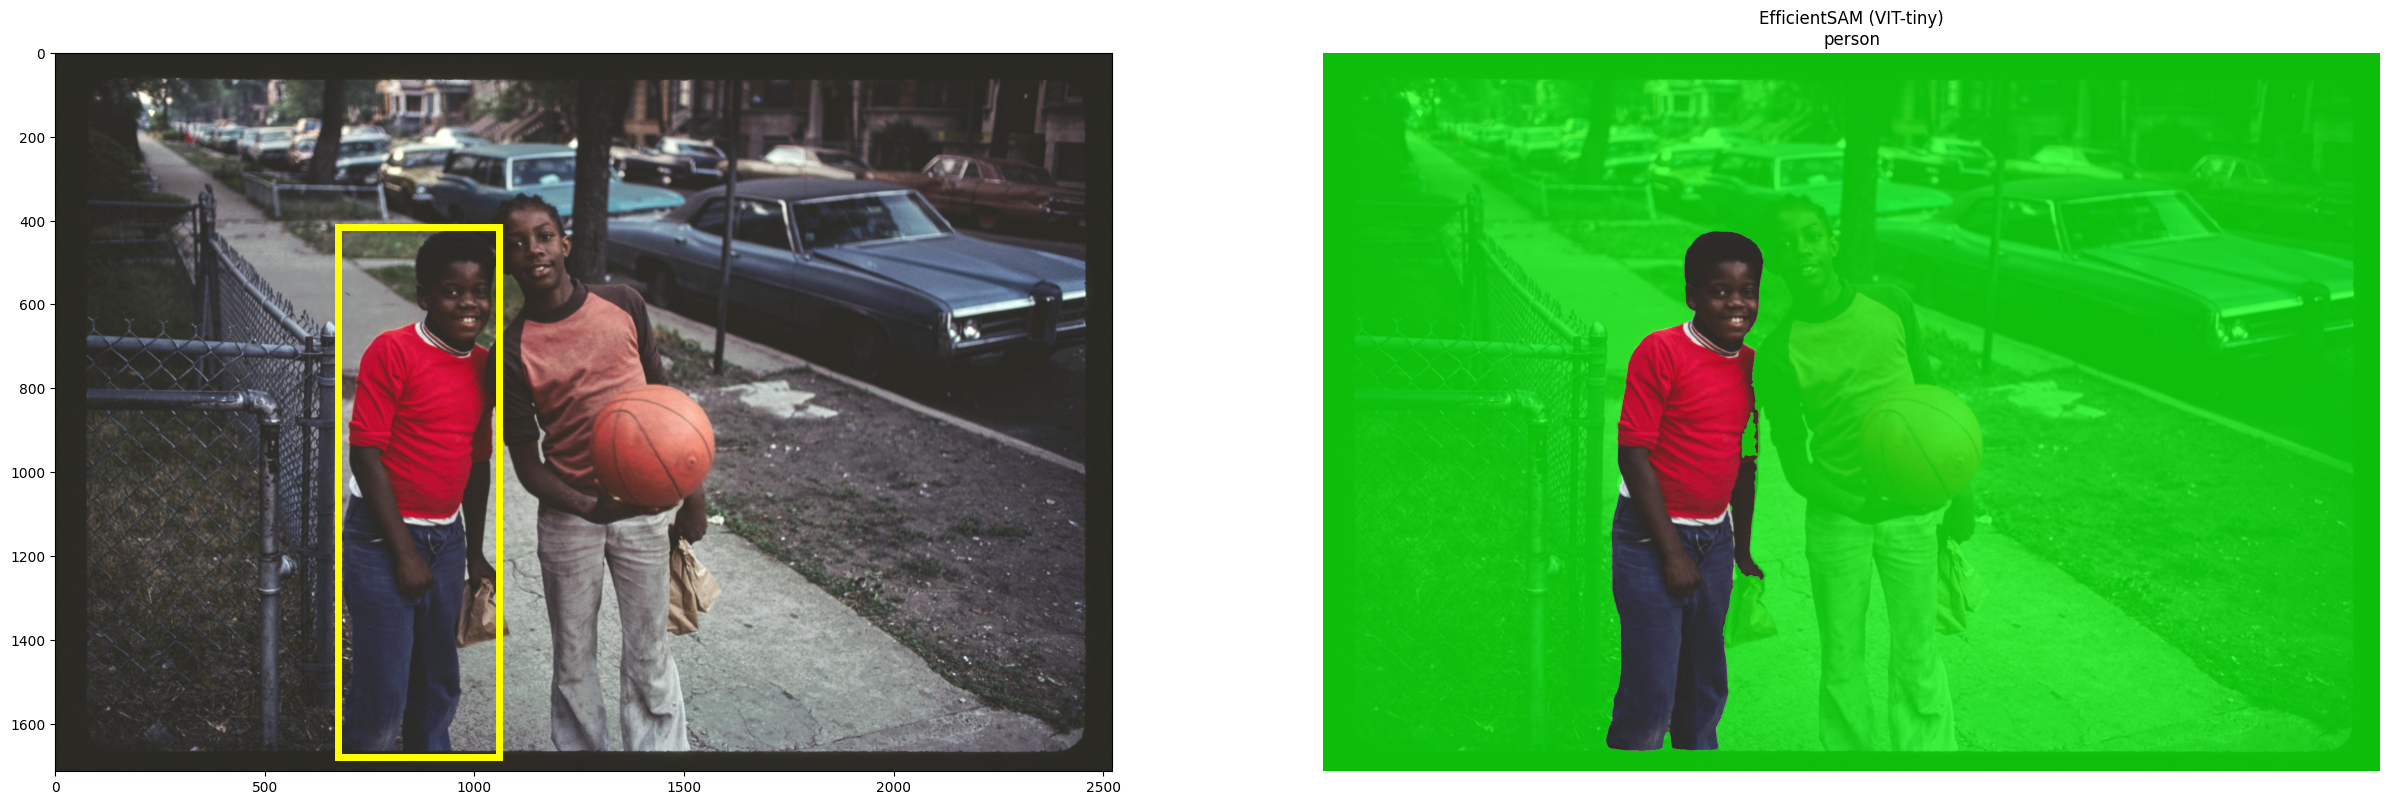

In [69]:
path = '/Users/aisaiahpellecer/Downloads/test_item:afc1981004.086.jpeg'

img = read_image(path)

batch = [preprocess(img)]

# Step 4: Use the model and visualize the prediction
prediction = model(batch)[0]
# labels = [weights.meta["categories"][i] for i in prediction["labels"]]
# box = draw_bounding_boxes(
#     img, boxes=prediction["boxes"], labels=labels, colors="red", width=4, font_size=30
# )
# im = to_pil_image(box.detach())

x1=prediction['boxes'][0][0].item() 
y1=prediction['boxes'][0][1].item()
x2=prediction['boxes'][0][2].item() 
y2=prediction['boxes'][0][3].item() 
w=x2-x1
h=y2-y1

fig, ax = plt.subplots(1, 2, figsize=(30, 30))
input_point = np.array([[x1, y1], [x2, y2]])
input_label = np.array([2,3])
image_path = path
image = np.array(Image.open(image_path))
show_points(input_point, input_label, ax[0])
show_box([x1,y1,x2,y2], ax[0])
ax[0].imshow(image)

ax[1].imshow(image)
mask_efficient_sam_vitt = run_ours_box_or_points(image_path, input_point, input_label, efficient_sam_vitt_model)
show_anns_ours(mask_efficient_sam_vitt, ax[1])
ax[1].title.set_text(f"EfficientSAM (VIT-tiny)\n{weights.meta['categories'][prediction['labels'][0].item()]}")
ax[1].axis('off')

(-0.5, 2520.5, 1713.5, -0.5)

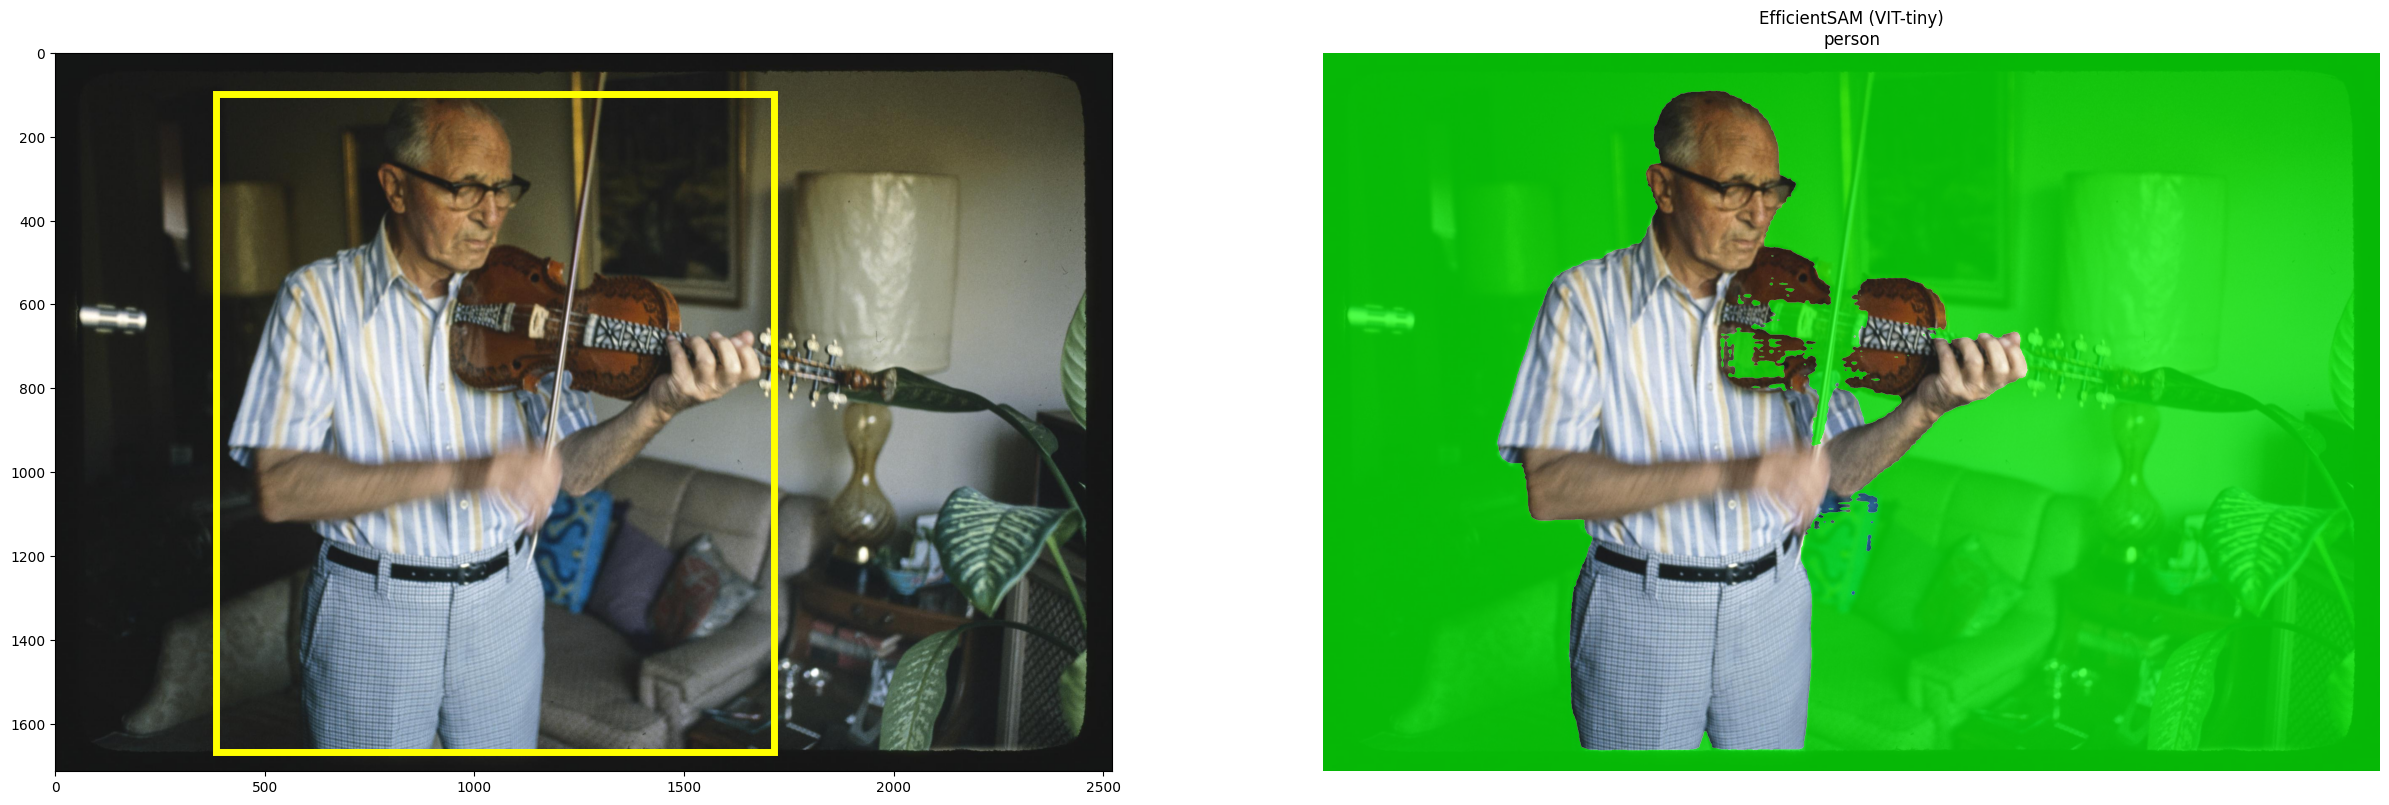

In [70]:
path = '/Users/aisaiahpellecer/Downloads/test_item:afc1981004.073:.jpeg'

img = read_image(path)

batch = [preprocess(img)]

# Step 4: Use the model and visualize the prediction
prediction = model(batch)[0]
# labels = [weights.meta["categories"][i] for i in prediction["labels"]]
# box = draw_bounding_boxes(
#     img, boxes=prediction["boxes"], labels=labels, colors="red", width=4, font_size=30
# )
# im = to_pil_image(box.detach())

x1=prediction['boxes'][0][0].item() 
y1=prediction['boxes'][0][1].item()
x2=prediction['boxes'][0][2].item() 
y2=prediction['boxes'][0][3].item() 
w=x2-x1
h=y2-y1

fig, ax = plt.subplots(1, 2, figsize=(30, 30))
input_point = np.array([[x1, y1], [x2, y2]])
input_label = np.array([2,3])
image_path = path
image = np.array(Image.open(image_path))
show_points(input_point, input_label, ax[0])
show_box([x1,y1,x2,y2], ax[0])
ax[0].imshow(image)

ax[1].imshow(image)
mask_efficient_sam_vitt = run_ours_box_or_points(image_path, input_point, input_label, efficient_sam_vitt_model)
show_anns_ours(mask_efficient_sam_vitt, ax[1])
ax[1].title.set_text(f"EfficientSAM (VIT-tiny)\n{weights.meta['categories'][prediction['labels'][0].item()]}")
ax[1].axis('off')

In [ ]:
path = '/Users/aisaiahpellecer/Downloads/test_item:afc1981004.073:.jpeg'

img = read_image(path)

batch = [preprocess(img)]

# Step 4: Use the model and visualize the prediction
prediction = model(batch)[0]
# labels = [weights.meta["categories"][i] for i in prediction["labels"]]
# box = draw_bounding_boxes(
#     img, boxes=prediction["boxes"], labels=labels, colors="red", width=4, font_size=30
# )
# im = to_pil_image(box.detach())

x1=prediction['boxes'][0][0].item() 
y1=prediction['boxes'][0][1].item()
x2=prediction['boxes'][0][2].item() 
y2=prediction['boxes'][0][3].item() 
w=x2-x1
h=y2-y1

fig, ax = plt.subplots(1, 2, figsize=(30, 30))
input_point = np.array([[x1, y1], [x2, y2]])
input_label = np.array([2,3])
image_path = path
image = np.array(Image.open(image_path))
show_points(input_point, input_label, ax[0])
show_box([x1,y1,x2,y2], ax[0])
ax[0].imshow(image)

ax[1].imshow(image)
mask_efficient_sam_vitt = run_ours_box_or_points(image_path, input_point, input_label, efficient_sam_vitt_model)
show_anns_ours(mask_efficient_sam_vitt, ax[1])
ax[1].title.set_text(f"EfficientSAM (VIT-tiny)\n{weights.meta['categories'][prediction['labels'][0].item()]}")
ax[1].axis('off')